 ## Ciencia de Datos - Universidad de Los Andes
 ## Segunda Entrega - Proyecto Final (Parte 3)
 
 ### Integrantes: Andrés Araque, David Cargua, Cristian Bravo

 Este notebook contiene la construcción e implementación de un modelo de clasificación utilizando un dataset con la información de siniestros viales en Bogotá D.C.

In [21]:
 ## Imports para procesamiento

import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import random
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import graphviz

from  scipy.stats import chi2_contingency

from sklearn.model_selection import  cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz
from sklearn.externals import joblib

random.seed(202120)

In [22]:
## Leer el dataset

df_final = pd.read_csv('completo_codificado.csv', sep=',', encoding='latin-1')
df_final

,CANTIDAD_ACCIDENTES,Poblacion,Extension,Urbana,Rural,Indice,ACCIDENTALIDAD,Dia_is_1,Dia_is_2,Dia_is_3,Dia_is_4,Dia_is_5,Dia_is_6,Dia_is_7,Localidad_is_1,Localidad_is_2,Localidad_is_3,Localidad_is_4,Localidad_is_5,Localidad_is_6,Localidad_is_7,Localidad_is_8,Localidad_is_9,Localidad_is_10,Localidad_is_11,Localidad_is_12,Localidad_is_13,Localidad_is_14,Localidad_is_15,Localidad_is_16,Localidad_is_17,Localidad_is_18,Localidad_is_19,Localidad_is_20,Mes_is_1,Mes_is_2,Mes_is_3,Mes_is_4,Mes_is_5,Mes_is_6,Mes_is_7,Mes_is_8,Mes_is_9,Mes_is_10,Mes_is_11,Mes_is_12,Hora_is_0,Hora_is_1,Hora_is_2,Hora_is_3,Hora_is_4,Hora_is_5,Hora_is_6,Hora_is_7,Hora_is_8,Hora_is_9,Hora_is_10,Hora_is_11,Hora_is_12,Hora_is_13,Hora_is_14,Hora_is_15,Hora_is_16,Hora_is_17,Hora_is_18,Hora_is_19,Hora_is_20,Hora_is_21,Hora_is_22,Hora_is_23
0,2,571268,65.54,1,0,0.035010,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,571268,65.54,1,0,0.035010,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,571268,65.54,1,0,0.035010,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4,571268,65.54,1,0,0.070020,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,571268,65.54,1,0,0.017505,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152484,4,3584,780.96,0,1,11.160714,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
152485,1,3584,780.96,0,1,2.790179,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
152486,1,3584,780.96,0,1,2.790179,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
152487,2,3584,780.96,0,1,5.580357,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [23]:
## Selección de variable objetivo 

X = df_final.drop('ACCIDENTALIDAD',axis=1)
X = X.drop('CANTIDAD_ACCIDENTES',axis=1)
X = X.drop('Indice',axis=1)
Y = df_final['ACCIDENTALIDAD']
print(X.head())
print(Y)

   Poblacion  Extension  Urbana  ...  Hora_is_21  Hora_is_22  Hora_is_23
0     571268      65.54       1  ...           0           0           0
1     571268      65.54       1  ...           0           0           0
2     571268      65.54       1  ...           0           0           0
3     571268      65.54       1  ...           0           0           0
4     571268      65.54       1  ...           0           0           0

[5 rows x 67 columns]
0         0
1         0
2         0
3         1
4         0
         ..
152484    2
152485    2
152486    2
152487    2
152488    2
Name: ACCIDENTALIDAD, Length: 152489, dtype: int64


In [24]:
## Dividir datasets en entrenamiento y validación

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 100)

**<h4> La búsqueda de parámetros óptimos para los modelos de árbol de decisión y random forest se implementarion en los notebooks DT.ipynb y RF.ipynb**

In [25]:
## Crear árbol de decisión para clasificacion

clf = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3, min_samples_leaf=1, min_samples_split = 2)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

In [26]:
## Función para la predicción

def pred(X_test, clf):
    y_pred = clf.predict(X_test)
    return y_pred

pred(X_test,clf)

array([2, 2, 2, ..., 1, 0, 0])

In [27]:
# Función para calcular las métricas accuracy y presicion

def metricas(y_test, y_pred):
    print("Matriz de confusión: ", confusion_matrix(y_test, y_pred))      
    print("Precisión : ", accuracy_score(y_test,y_pred)*100)      
    print("Reporte : ", classification_report(y_test, y_pred))

metricas(y_test, pred(X_test,clf))

Matriz de confusión:  [[18226   528     0]
 [ 3126  8717   431]
 [  144  1229 13346]]
Precisión :  88.06916300522438
Reporte :                precision    recall  f1-score   support

           0       0.85      0.97      0.91     18754
           1       0.83      0.71      0.77     12274
           2       0.97      0.91      0.94     14719

    accuracy                           0.88     45747
   macro avg       0.88      0.86      0.87     45747
weighted avg       0.88      0.88      0.88     45747



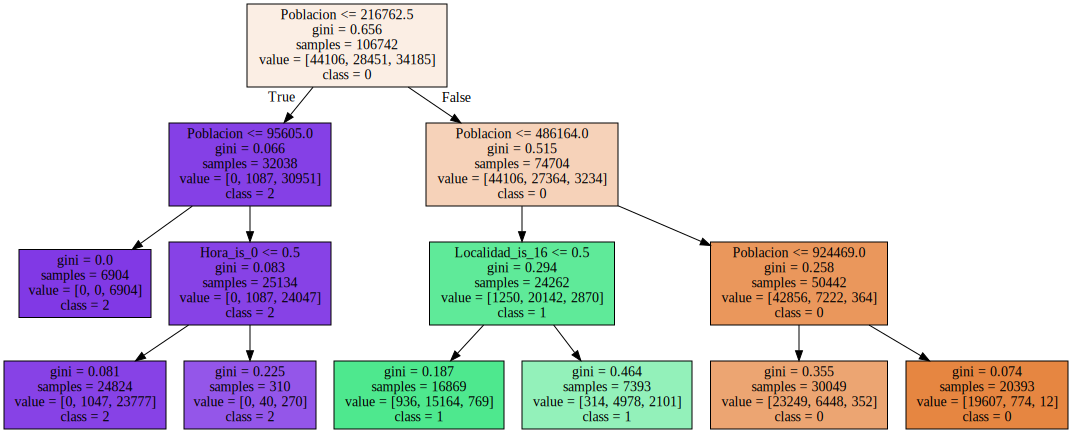

In [28]:
## Gráfico del árbol de decisión

dot_data = tree.export_graphviz(clf, out_file = None, 
                                feature_names = X.columns,  
                                class_names = ['0','1','2'],
                                filled = True)
graph = graphviz.Source(dot_data, format="png") 
graph

In [29]:
## Parámetros para modelo de random forest, se usaron para calcular el search

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [30]:
## Modelo de Random Forest

rf = RandomForestClassifier(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 4,
 max_features = 'sqrt',
 max_depth = 20,
 bootstrap = False)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
## Evaluación de métricas

y_pred = pred(X_test, rf)
metricas(y_test, y_pred)

Matriz de confusión:  [[18225   529     0]
 [ 3125  8716   433]
 [  144  1228 13347]]
Precisión :  88.06697706953462
Reporte :                precision    recall  f1-score   support

           0       0.85      0.97      0.91     18754
           1       0.83      0.71      0.77     12274
           2       0.97      0.91      0.94     14719

    accuracy                           0.88     45747
   macro avg       0.88      0.86      0.87     45747
weighted avg       0.88      0.88      0.88     45747



In [32]:
## Guardar modelos, Exportando el modelo en disco

joblib.dump(clf, 'decision_tree_model.pkl') # Serialización
clf = joblib.dump(clf, 'decision_tree_model.pkl') # Deserialización

joblib.dump(rf, 'random_forest_model.pkl') # Serialización
rf = joblib.dump(rf, 'random_forest_model.pkl') # Deserialización